In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.callbacks import History 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from pylab import savefig
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
#read_csv
tweet_df = pd.read_csv("TrainingHashtag.csv")

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   author id         1340 non-null   float64
 1   created_at        1340 non-null   object 
 2   geo               1340 non-null   object 
 3   id                1340 non-null   object 
 4   language          1340 non-null   object 
 5   source            1340 non-null   object 
 6   tweet             1340 non-null   object 
 7   location          1340 non-null   object 
 8   bbox              1340 non-null   object 
 9   crime             1340 non-null   object 
 10  Category          1340 non-null   int64  
 11  lemmatized_tweet  1340 non-null   object 
 12  stemming_tweet    1340 non-null   object 
 13  clean_tweet_lem   1340 non-null   object 
 14  clean_tweet_stem  1340 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 157.2+ KB


In [ ]:
def BertTraining(X_train, y_train, X_test, y_test, x_valid, y_valid, epochs, data):
    
    #downlading pre-trained bert model
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

    def get_sentence_embeding(sentences):
        preprocessed_text = bert_preprocess(sentences)
        return bert_encoder(preprocessed_text)['pooled_output']

    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural network layers
    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])

    #strat training time
    t0 = time.time()

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    #early stopping function
    earlystopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

    #model checkpoint to save the best bert model
    modelcheckpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, 
                                      save_best_only=True)
    
    #train bert model
    history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), batch_size=32, epochs=epochs, 
                            callbacks = [earlystopping, modelcheckpoint])

    # load the saved model
    saved_model = load_model('best_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

    # plot training history
    pyplot.plot(history.history['loss'], label='Training loss')
    pyplot.plot(history.history['val_loss'], label='Validaton loss')
    pyplot.title('Training and Validation Loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig('LineChart_Bert ' + str(data) + '.png')
    pyplot.show()

    results = saved_model.evaluate(X_test, y_test)
    y_predicted = saved_model.predict(X_test)
    y_predicted = y_predicted.flatten()
    y_predicted = np.where(y_predicted > 0.5, 1, 0) #bert predicted values below 0.5 is considered as non-crime

    
    #confusion matrix
    conf_matrix = confusion_matrix(y_test, y_predicted)
    B_TP = conf_matrix[1][1]
    B_FP = conf_matrix[0][1]
    B_FN = conf_matrix[1][0]
    B_TN = conf_matrix[0][0]
    
    #evaluation measures
    B_Specifity = B_TN / (B_TN + B_FP)
    B_Error_rate = (B_FP + B_FN) / (B_TP + B_TN + B_FP + B_FN)

    print("----------- PERFORMANCE MEASURES ------------\n")

    print('Bert Accuracy -> %.4f' % accuracy_score(y_test, y_predicted))
    print('Bert Precision -> %.4f' % precision_score(y_test, y_predicted))
    print('Bert Recall -> %.4f' % recall_score(y_test, y_predicted))
    print('Bert F1 Score -> %.4f' % f1_score(y_test, y_predicted))
    print('Bert Specifity -> %.4f'% B_Specifity)
    print('Bert Error Rate -> %.4f'% B_Error_rate)
    print('Bert AUC Rate -> %.4f\n'% metrics.roc_auc_score(y_test, y_predicted))
    #print(cm)
    print("")
    print("Bert Training time ->", time.time()-t0, " seconds \n")

    #Confusion Matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    percentage = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)
    c_matrix = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    figure = c_matrix.get_figure()
    figure.savefig('CMatrix_Bert ' + str(data) + '.png')

    #Prediction part
    if data == "lem":
        unseen_test = tweet_df['clean_tweet_lem']
    elif data == 'stem':
        unseen_test = tweet_df['clean_tweet_stem']

    y_pred_unseen = model.predict(unseen_test)
    tweet_df["Bert_Prediction"] = y_pred_unseen
    tweet_df["Bert_Pred_Label"] = tweet_df["Bert_Prediction"].apply(lambda x: 1 if x > 0.5 else 0)
    tweet_df.sample(3)

    if data == "lem":
        tweet_df.to_csv("Bert_Prediction_Lem.csv", index=False)
    elif data == 'stem':
        tweet_df.to_csv("Bert_Prediction_Stem.csv", index=False)

## **Bert Model With Lemmatization**

In [ ]:
# In the first step we will split the data in training and remaining dataset
X_train_lem, X_rem_lem, y_train_lem, y_rem_lem = train_test_split(tweet_df['clean_tweet_lem'],tweet_df['Category'], train_size=0.8, stratify=tweet_df['Category'], random_state = 42)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid_lem, X_test_lem, y_valid_lem, y_test_lem = train_test_split(X_rem_lem, y_rem_lem, test_size=0.5, random_state = 42)

In [ ]:
X_train_lem.head(4)

352     teen fatally stab ilford boy hold suspicion mu...
239     cyclist jail tower hamlet hitandrun death know...
889     christmas dinner sort shout work today happy c...
1101          stein say I not phone police sound familiar
Name: clean_tweet_lem, dtype: object

In [ ]:
print(X_train_lem.shape, y_train_lem.shape)
print(X_test_lem.shape, y_test_lem.shape)
print(X_valid_lem.shape, y_valid_lem.shape)

(1072,) (1072,)
(134,) (134,)
(134,) (134,)


Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5280
Epoch 1: val_accuracy improved from -inf to 0.63433, saving model to best_model.h5
34/34 [==============================] - 24s 464ms/step - loss: 0.6934 - accuracy: 0.5280 - val_loss: 0.6570 - val_accuracy: 0.6343
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6241
Epoch 2: val_accuracy improved from 0.63433 to 0.71642, saving model to best_model.h5
34/34 [==============================] - 15s 445ms/step - loss: 0.6531 - accuracy: 0.6241 - val_loss: 0.6360 - val_accuracy: 0.7164
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.6688
Epoch 3: val_accuracy did not improve from 0.71642
34/34 [==============================] - 13s 390ms/step - loss: 0.6300 - accuracy: 0.6688 - val_loss: 0.6377 - val_accuracy: 0.6269
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7034
Epoc

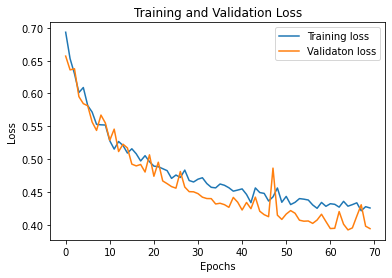

5/5 [==============================] - 2s 335ms/step
----------- PERFORMANCE MEASURES ------------

Bert Accuracy -> 0.8433
Bert Precision -> 0.8254
Bert Recall -> 0.8387
Bert F1 Score -> 0.8320
Bert Specifity -> 0.8472
Bert Error Rate -> 0.1567
Bert AUC Rate -> 0.8430


Bert Training time -> 963.6081345081329  seconds 

42/42 [==============================] - 15s 338ms/step


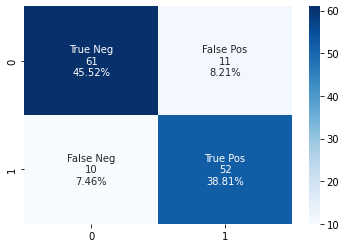

In [ ]:
# Running BERT Model with 100 epochs to find the optimal epochs
BertTraining(X_train_lem, y_train_lem, X_test_lem, y_test_lem, X_valid_lem, y_valid_lem, 100, 'lem')

In [ ]:
pred_lem_df = pd.read_csv("Bert_Prediction_Lem.csv")
pred_lem_df.groupby('Bert_Pred_Label').describe()

author id                                                      \
                    count          mean           std        min          25%   
Bert_Pred_Label                                                                 
0                   557.0  2.558602e+17  4.746677e+17  2597581.0  126668055.0   
1                   783.0  2.327673e+17  4.704032e+17  1612011.0  113144389.0   

                                                         Category            \
                         50%           75%           max    count      mean   
Bert_Pred_Label                                                               
0                465420095.0  3.486142e+09  1.444056e+18    557.0  0.122083   
1                242235183.0  2.957995e+09  1.471594e+18    783.0  0.768838   

                 ...           Bert_Prediction                                \
                 ...  75%  max           count      mean       std       min   
Bert_Pred_Label  ...                                                           
0                ...  0.0  1.0           557.0  0.238830  0.141118  0.012137   
1                ...  1.0  1.0           783.0  0.783333  0.132216  0.500467   

                                                         
                      25%       50%       75%       max  
Bert_Pred_Label                                          
0                0.112660  0.216577  0.367171  0.499995  
1                0.687908  0.799352  0.895912  0.994928  

[2 rows x 24 columns]

## **Bert Model With Stemming**

In [ ]:
# In the first step we will split the data in training and remaining dataset
X_train_stem, X_rem_stem, y_train_stem, y_rem_stem = train_test_split(tweet_df['clean_tweet_stem'],tweet_df['Category'], train_size=0.8, stratify=tweet_df['Category'], random_state = 42)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid_stem, X_test_stem, y_valid_stem, y_test_stem = train_test_split(X_rem_stem, y_rem_stem, test_size=0.5, random_state = 42)

In [ ]:
X_train_stem.head(4)

352     teen fatal stab ilford boy held suspicion murd...
239     cyclist jail tower hamlet hitandrun death know...
889     christma dinner sort shout work today happi ch...
1101         stein said im not phone polic sound familiar
Name: clean_tweet_stem, dtype: object

In [ ]:
print(X_train_stem.shape, y_train_stem.shape)
print(X_test_stem.shape, y_test_stem.shape )
print(X_valid_stem.shape, y_valid_stem.shape)

(1072,) (1072,)
(134,) (134,)
(134,) (134,)


Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5271
Epoch 1: val_accuracy improved from -inf to 0.49254, saving model to best_model.h5
34/34 [==============================] - 24s 474ms/step - loss: 0.6964 - accuracy: 0.5271 - val_loss: 0.6809 - val_accuracy: 0.4925
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.6166
Epoch 2: val_accuracy improved from 0.49254 to 0.57463, saving model to best_model.h5
34/34 [==============================] - 15s 447ms/step - loss: 0.6562 - accuracy: 0.6166 - val_loss: 0.6579 - val_accuracy: 0.5746
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6511
Epoch 3: val_accuracy improved from 0.57463 to 0.62687, saving model to best_model.h5
34/34 [==============================] - 15s 440ms/step - loss: 0.6322 - accuracy: 0.6511 - val_loss: 0.6402 - val_accuracy: 0.6269
Epoch 4/100
34/34 [==============================] - ETA: 0s - l

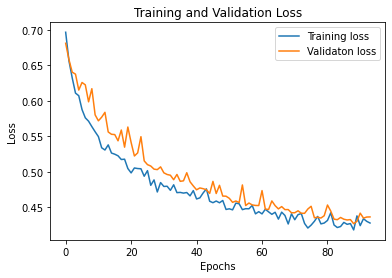

5/5 [==============================] - 2s 321ms/step
----------- PERFORMANCE MEASURES ------------

Bert Accuracy -> 0.7985
Bert Precision -> 0.7612
Bert Recall -> 0.8226
Bert F1 Score -> 0.7907
Bert Specifity -> 0.7778
Bert Error Rate -> 0.2015
Bert AUC Rate -> 0.8002


Bert Training time -> 1286.9367055892944  seconds 

42/42 [==============================] - 15s 339ms/step


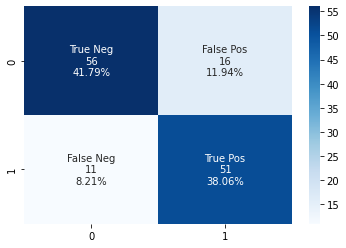

In [ ]:
# Running BERT Model with 100 epochs to find the optimal
BertTraining(X_train_stem, y_train_stem, X_test_stem, y_test_stem, X_valid_stem, y_valid_stem, 100, 'stem')

In [ ]:
pred_stem_df = pd.read_csv("Bert_Prediction_Stem.csv")
pred_stem_df.groupby('Bert_Pred_Label').describe()

author id                                                      \
                    count          mean           std        min          25%   
Bert_Pred_Label                                                                 
0                   671.0  2.734449e+17  4.866347e+17  1612011.0  127936564.5   
1                   669.0  2.111949e+17  4.553785e+17  1612011.0  105801267.0   

                                                         Category            \
                         50%           75%           max    count      mean   
Bert_Pred_Label                                                               
0                557414073.0  4.901952e+09  1.444056e+18    671.0  0.177347   
1                186365425.0  2.389337e+09  1.471594e+18    669.0  0.823617   

                 ...           Bert_Prediction                                \
                 ...  75%  max           count      mean       std       min   
Bert_Pred_Label  ...                                                           
0                ...  0.0  1.0           671.0  0.225251  0.144380  0.004484   
1                ...  1.0  1.0           669.0  0.762241  0.130362  0.500197   

                                                         
                      25%       50%       75%       max  
Bert_Pred_Label                                          
0                0.100122  0.204241  0.352072  0.499987  
1                0.641478  0.780558  0.875259  0.986900  

[2 rows x 24 columns]

Lemmatized BERT model performed better than stemmed model

<h1>Reference - </h1>

source code - https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb

video - https://youtu.be/hOCDJyZ6quA

https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/